In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pandas as pd
import cv2
import random
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
random.seed(40)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
top_dir = '/kaggle/input/glasses-or-no-glasses'
os.listdir(top_dir)

['faces-spring-2020', 'train.csv', 'test.csv']

# Problem Description

The goal of this project is to determine whether or not the person in the image is wearing glasses or not. The dataset of images for which we will be classifying were produced from a Generative Adversarial Network (GAN). The GAN takes in a 512 dimension latent vector. The latent vector and produced image are given to us. For this project, I will be using the images to predict whether or not the individual is wearing glasses.

[1] https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses/data

# EDA

## Data Description
The data used in this project [1] comes from a Kaggle dataset. The data has already been split into train and test sets. The test set is used for scoring with the associated Kaggle competition. To evaluate the deep learning model as we train, I will split the training dataset into a training and validation set. The Kaggle dataset contains 4,500 training images and 500 test images. In the train.csv provided, there is an ID column, glasses target, and the 512 latent vector entries. In the test.csv, there is an ID column and the 512 latent vector entries. The images are provided in a subdirectory and are labeled with the following format: "face-\<ID\>.png".


Each image is 1024x1024x3 pixels. There are 3 layers for the RGB layers. 

In [3]:
# Load in the data IDs and labels
train_labels_df = pd.read_csv(os.path.join(top_dir, 'train.csv'))[['id', 'glasses']]
test_ids = pd.read_csv(os.path.join(top_dir, 'test.csv'))['id'].values

In [4]:
# Let's explore a few images
image_dir = os.path.join(top_dir, 'faces-spring-2020', 'faces-spring-2020')
image_files = os.listdir(image_dir)

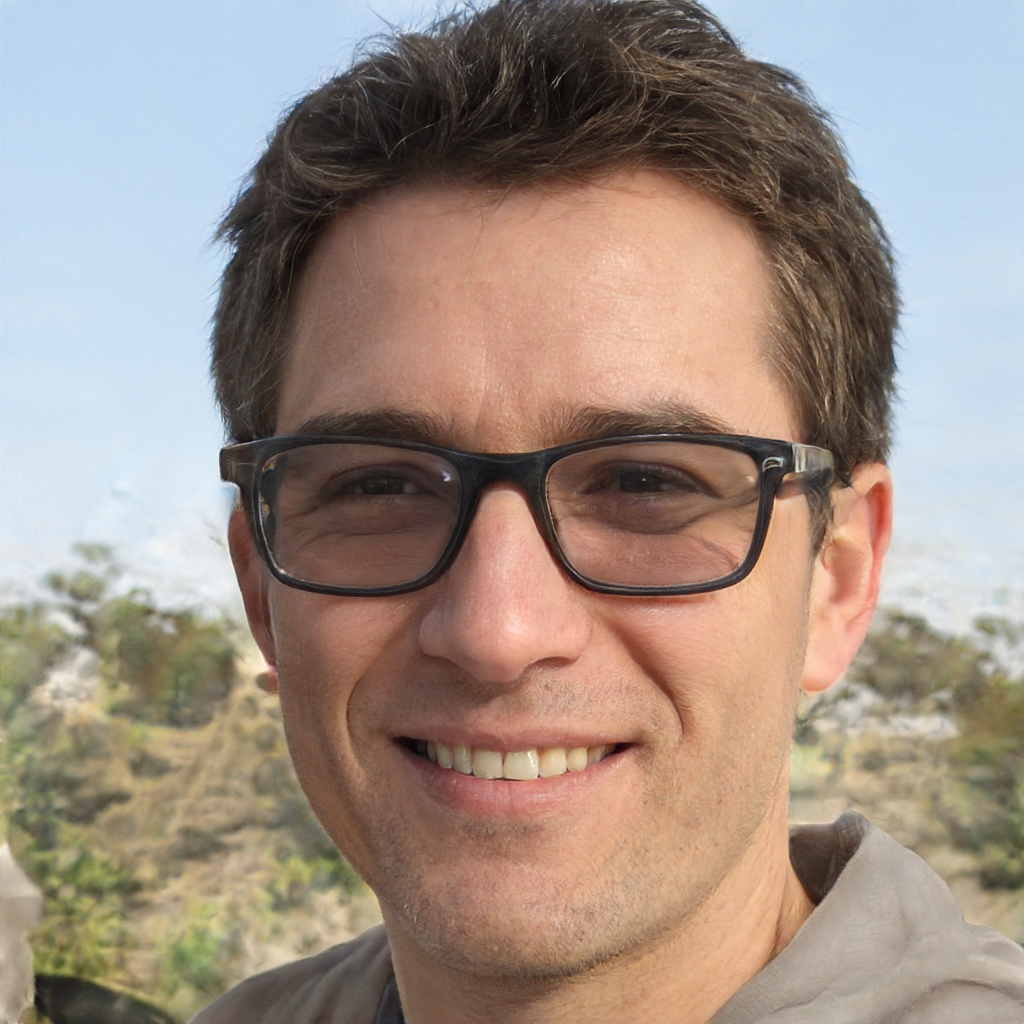

In [5]:
# Training image with glasses
PIL.Image.open(os.path.join(image_dir, image_files[0]))

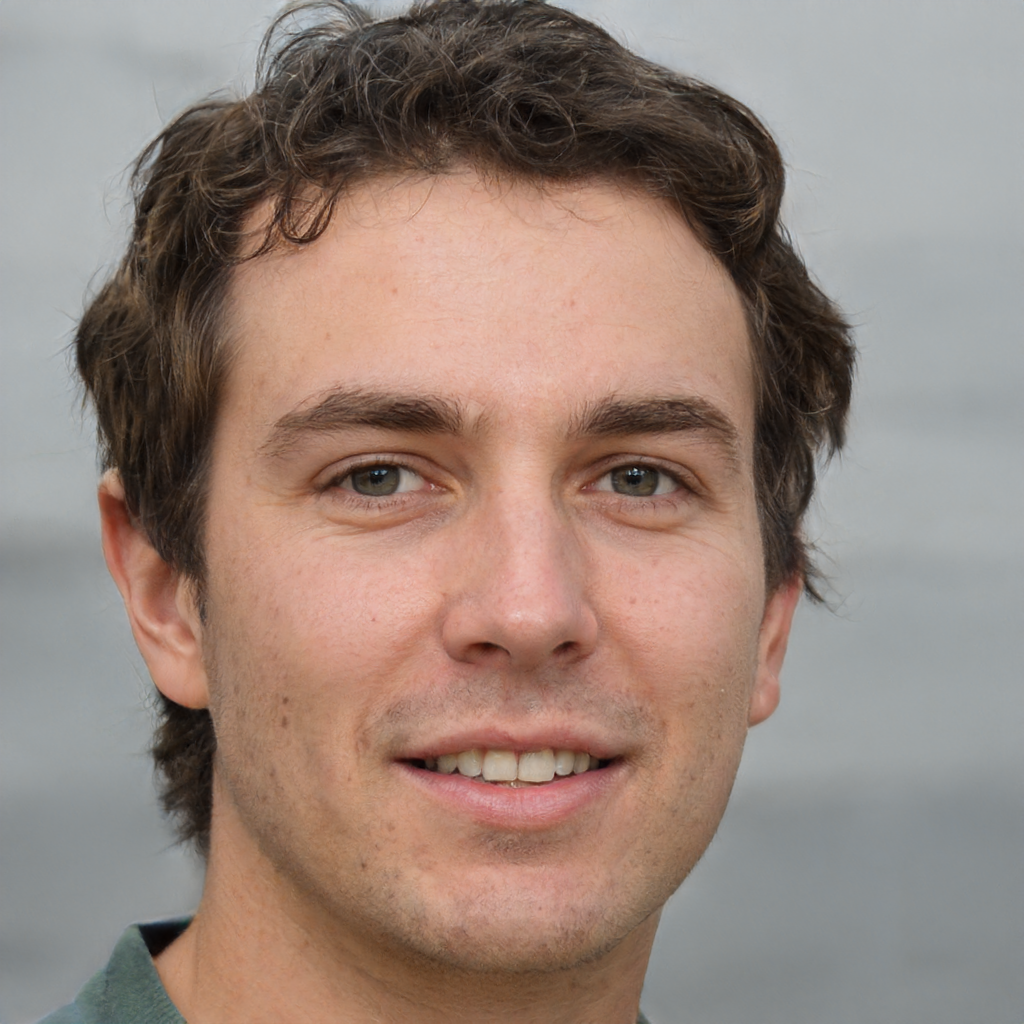

In [6]:
# Training image without glasses
PIL.Image.open(os.path.join(image_dir, image_files[1]))

In [7]:
# Testing image with glasses
PIL.Image.open(os.path.join(image_dir, image_files[4501]))

In [8]:
# Testing image without glasses
PIL.Image.open(os.path.join(image_dir, image_files[4530]))

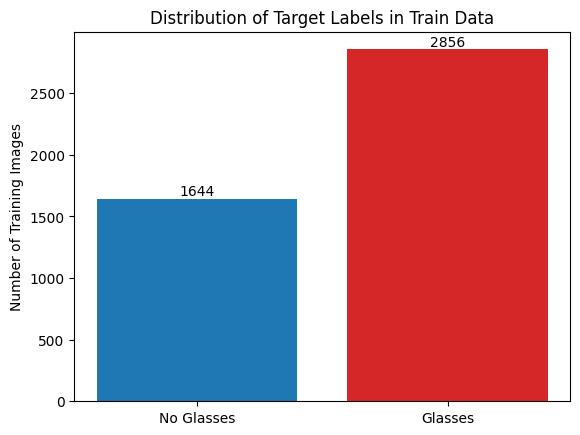

In [9]:
# Look at data label balance in the train data
num_glasses = train_labels_df[train_labels_df['glasses'] == 1].shape[0]
num_no_glasses = train_labels_df[train_labels_df['glasses'] == 0].shape[0]
bar_colors = ['tab:blue', 'tab:red']
bars = plt.bar(['No Glasses', 'Glasses'], [num_no_glasses, num_glasses], color=bar_colors)
plt.ylabel('Number of Training Images')
plt.bar_label(bars)
plt.title('Distribution of Target Labels in Train Data')
plt.show()
plt.close()

**Data Cleaning Explanation and Justifiction:** There is a substantial difference in the available training data for people with glasses. It is likely that our model will overpredict glasses with this training distribution.

To correct for this I will randomly sample 1,500 images from each subset. Then we will split the data into train and validation IDs and evaluate if the given split yields even sets of training labels.

In [10]:
# Get IDs for training data with and without glasses
glasses_ids = list(train_labels_df[train_labels_df['glasses'] == 1]['id'])
no_glasses_ids = list(train_labels_df[train_labels_df['glasses'] == 0]['id'])

# Down sample to have an even number of target label samples
downsampled_glasses_ids = random.sample(glasses_ids, 1500)
downsampled_no_glasses_ids = random.sample(no_glasses_ids, 1500)

# Downselect the train labels dataframe
keep_ids = downsampled_glasses_ids + downsampled_no_glasses_ids
mask = train_labels_df['id'].isin(keep_ids)
downsampled_train_labels_df = train_labels_df.loc[mask]

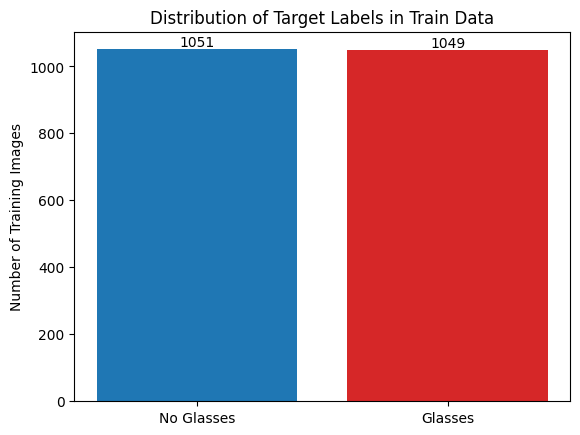

In [11]:
# Split data into training and validation and evaluate distribution
X_train_ids, X_val_ids, y_train, y_val = train_test_split(downsampled_train_labels_df['id'], downsampled_train_labels_df['glasses'], test_size=0.3, random_state=0)

bar_colors = ['tab:blue', 'tab:red']
bars = plt.bar(['No Glasses', 'Glasses'], [sum(y_train == 0), sum(y_train == 1)], color=bar_colors)
plt.ylabel('Number of Training Images')
plt.bar_label(bars)
plt.title('Distribution of Target Labels in Train Data')
plt.show()
plt.close()

bars = plt.bar(['No Glasses', 'Glasses'], [sum(y_val == 0), sum(y_val == 1)], color=bar_colors)
plt.ylabel('Number of Validation Images')
plt.bar_label(bars)
plt.title('Distribution of Target Labels in Validation Data')
plt.show()
plt.close()

These are much more evenly distributed splits of training and validation data labels. Next we must load the images into a dataset with the given labels.

Data should be normalized between 0 and 1 before being input into a model.

In [12]:
def load_image(image_file, label):
    # Read file as a tf object
    raw_image = tf.io.read_file(image_file)
    # Decode to three channels
    image = tf.io.decode_image(raw_image, channels = 3)
    # Cleaning: Normalize image between 0 and 1
    image = tf.cast(image, tf.float32)  / 255
    # Reshape image to size
    image = tf.reshape(image, [1, 1024, 1024, 3])
    # Return image
    return image, label

def create_dataset(files, labels):
    # Load dataset as a tf Dataset object from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    # Map each file to the decoded image
    dataset = dataset.map(load_image)
    # Return dataset object
    return dataset

def load_test_image(image_file):
    return load_image(image_file, None)[0]

def create_test_dataset(files):
    # Load dataset as a tf Dataset object from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((files))
    # Map each file to the decoded image
    dataset = dataset.map(load_test_image)
    # Return dataset object
    return dataset

In [13]:
# Get image paths
train_image_paths = [os.path.join(image_dir, 'face-' + str(img_id) + '.png') for img_id in X_train_ids]
val_image_paths = [os.path.join(image_dir, 'face-' + str(img_id) + '.png') for img_id in X_val_ids]
test_image_paths = [os.path.join(image_dir, 'face-' + str(img_id) + '.png') for img_id in test_ids]

# Reshape labels
y_train = np.asarray(y_train.values).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val.values).astype('float32').reshape((-1,1))

# Create train, validation, and test dataset 
train_dataset = create_dataset(train_image_paths, y_train)
val_dataset = create_dataset(val_image_paths, y_val)
test_dataset = create_test_dataset(test_image_paths)

We have a train, val, and test dataset available. The plan is to use a CNN to classify the images as a person wearing or not wearing glasses. CNN models typically perform better with normalized data, we cleaned the dataset to be normalized between 0 and 1. We also ensured that the training dataset labels were balanced as to not skew the model weights to over or underpredict glasses. 

# Model Building

Model Architecture: We will start with a very simple CNN. The input layer will be a Convolutional 2D layer with a (3,3) kernel and ReLU activation. The first hidden layer will be another convolutional 2D layer with the same kernel and ReLU activation. Then we will have a MaxPooling layer. Then we will flatten the image and predict the probability that the image contains a person wearing glasses with a sigmoid activation function and a dense layer. 

Adam optimization is typically the best optimizer for CNNs. So, we will compile the model with the Adam optimizer with the default learning rate. We will start with BinaryCrossentropy as the loss function, and we will evalute the model with AUC as we are predicting the probability that the image contains glasses.

This is a very simple CNN model. If accuracy is not very good for this architecture, we will add more complexity, with more Convolution layers, potentially adding dropout or normalization layers, and potentially adding more dense layers at the end of the model. 

In [22]:
def build_small_model(stride=1):
    model = models.Sequential()
    # 2 Convolutional layers with max pooling layer
    model.add(layers.Conv2D(32, (3,3), strides=stride, activation='relu', input_shape=(1024, 1024, 3)))
    model.add(layers.Conv2D(32, (3,3), strides=stride, activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten before dense layer
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # Print model summary
    model.summary()
    return model

In [15]:
initial_model = build_small_model()
initial_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['AUC'])
initial_history = initial_model.fit(x=train_dataset, batch_size=100, epochs=5, validation_data=val_dataset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1022, 1022, 32)    896       
                                                                 
 conv2d_1 (Conv2D)           (None, 1020, 1020, 32)    9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 510, 510, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8323200)           0         
                                                                 
 dense (Dense)               (None, 1)                 8323201   
                                                                 
Total params: 8,333,345
Trainable params: 8,333,345
Non-trainable params: 0
______________________________________________

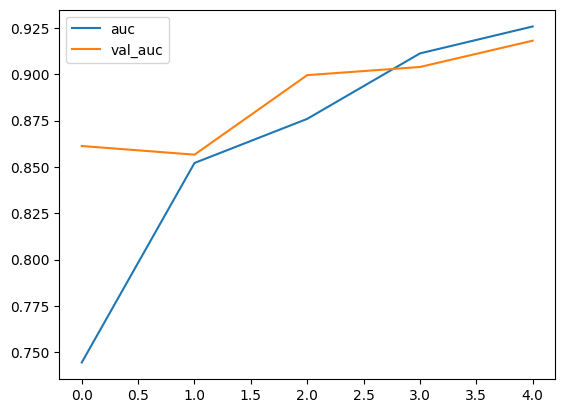

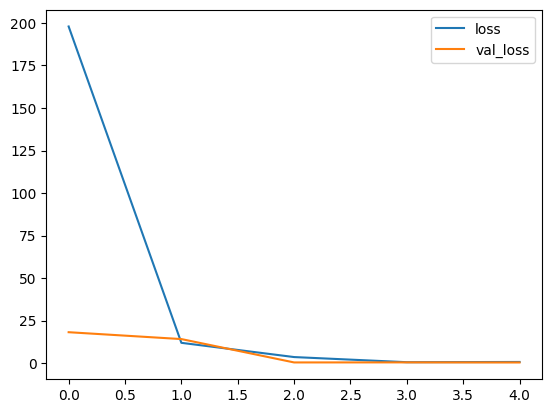

In [16]:
metrics = pd.DataFrame(initial_history.history)
metrics[["auc","val_auc"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

This model architecture is simple and shows great promise for learning well. We will see if a more complex architecture can do something similar. In this next model architecture, we will use three levels of convolutional layers and max pooling as well as a dropout layer near the output layer. This should hopefully allow the model to learn smaller features of the datset that may capture the shapes of the glasses better than the very simple model. 

In [17]:
def build_model(drop_out_rate=0.1, strides=2):
    model = models.Sequential()
    # 2 Convolution layers with max pooling layer
    model.add(layers.Conv2D(32, (3,3), strides=strides, activation='relu', input_shape=(1024, 1024, 3)))
    model.add(layers.Conv2D(32, (3,3), strides=strides, activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # 2 Convolution layers with max pooling layer
    model.add(layers.Conv2D(64, (3,3), strides=strides, activation='relu'))
    model.add(layers.Conv2D(64, (3,3), strides=strides, activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # 2 Convolution layers with max pooling layer
    model.add(layers.Conv2D(128, (3,3), strides=strides, activation='relu'))
    model.add(layers.Conv2D(128, (3,3), strides=strides, activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten prior to dense layers
    model.add(layers.Flatten())
    # Dropout layer
    model.add(layers.Dropout(drop_out_rate))
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # Print model summary
    model.summary()
    return model

In [18]:
model = build_model()
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['AUC'])
history = model.fit(x=train_dataset, epochs=5, validation_data=val_dataset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 511, 511, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 255, 255, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                  

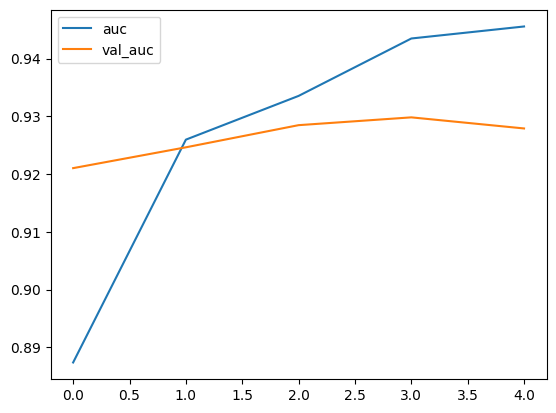

In [19]:
metrics = pd.DataFrame(history.history)
metrics[["auc","val_auc"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

# Results and Analysis

This second, more complex architecture CNN, shows more signs of overfitting. The validation AUC increases while the training AUC decreases. We will perform hyperparameter tuning to improve model accuracy and reduce overfitting of the first model architecture.

Hyperparameter Tuning Process: I will iterate through a set of learning rate, drop out rate, and stride options to determine which yield the highest Validation AUC after 10 epochs. The summary of Val AUC is stored to be reported. 

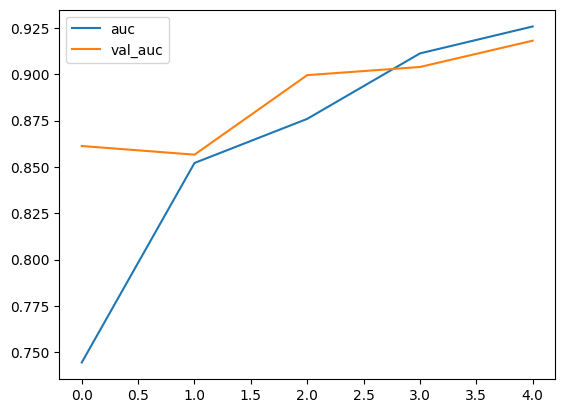

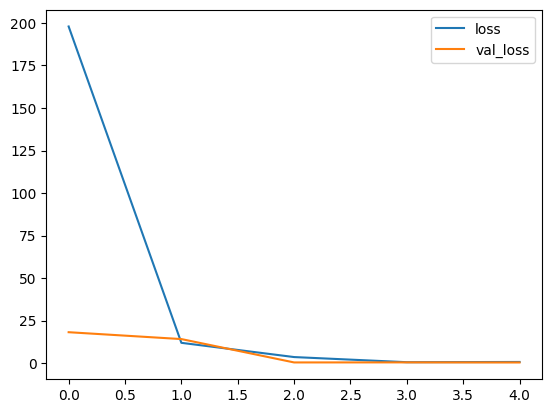

In [27]:
# Initial Model Results
metrics = pd.DataFrame(initial_history.history)
metrics[["auc","val_auc"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

In [23]:
# options
learning_rates = [0.00001, 0.0001]
strides = [1, 2, 3]

# Setup best storing
best_val_auc = 0
best_lr = None
best_stride = None
best_model = None
best_hist = None
report = "| Learning Rate | Stride | Validation AUC |\n"

# Iterate through options
for lr in learning_rates:
    for stride in strides:
        tmp_model = build_small_model(stride=stride)
        tmp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['AUC'])
        history = tmp_model.fit(x=train_dataset, epochs=5, validation_data=val_dataset)
        val_auc = history.history['val_auc'][-1]
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_lr = lr
            best_stride = stride
            best_model = tmp_model
            best_hist = history
        report += f"| {lr} | {stride} | {val_auc} |\n"

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 1022, 1022, 32)    896       
                                                                 
 conv2d_15 (Conv2D)          (None, 1020, 1020, 32)    9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 510, 510, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 8323200)           0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8323201   
                                                                 
Total params: 8,333,345
Trainable params: 8,333,345
Non-trainable params: 0
____________________________________________

### Summary table of the Hyperparameter Tuning

In [49]:
print(report)

| Learning Rate | Stride | Validation AUC |
| 1e-05 | 1 | 0.951542854309082 |
| 1e-05 | 2 | 0.9435280561447144 |
| 1e-05 | 3 | 0.9204292297363281 |
| 0.0001 | 1 | 0.8927624225616455 |
| 0.0001 | 2 | 0.9490959644317627 |
| 0.0001 | 3 | 0.9484811425209045 |



The best validation AUC, learning rate, drop out rate, and stride are shown below.

In [50]:
print(f"Best Val AUC: {best_val_auc}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Stride: {best_stride}")

Best Val AUC: 0.951542854309082
Best Learning Rate: 1e-05
Best Stride: 1


We will view the epoch history from the best model. 

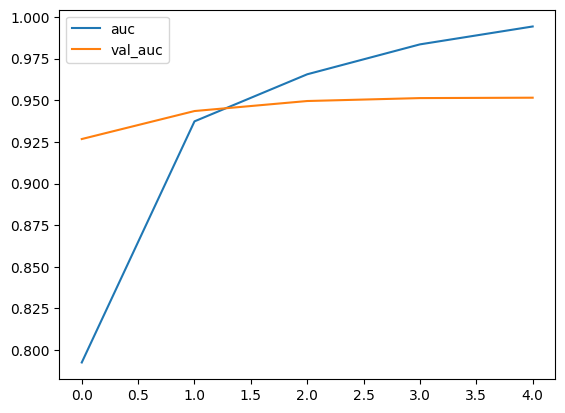

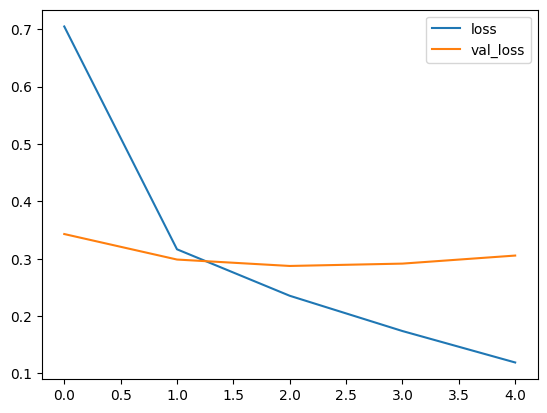

In [26]:
metrics = pd.DataFrame(best_hist.history)
metrics[["auc","val_auc"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

We see that there is some overfitting in this model. It actually appears (looking through the epoch reports) that the best hyperparameters were a learning rate of 1e-05 and a stride of 2. That does reduce the final Validation AUC to 0.9435280561447144. But theree is less overfitting present with those hyperparameters. 

# Conclusion

Summary: Given an artificial set of images, produced by a GAN, with people with and without glasses, we developed a CNN model that can classify whether or not the individual in the image is wearing glasses or not. 

Key Takeaways: A simple CNN architecture is very powerful and can detect small features. 

What went wrong: The hyperparameter tuning reported best model based on the ending validation AUC but missed that the model with the highest validation AUC had overfitting. 

Future Improvements: Including a callback function with EarlyStopping capabilities and keeping the best epoch not just the final epoch could improve the resulting validation AUC without reporting the best model that had overfitting.